In [1]:
from google.cloud import bigquery
import pandas as pd
import google
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

# Establece la variable de entorno GOOGLE_APPLICATION_CREDENTIALS con la ruta al archivo de credenciales
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:/Users/raul.raggio/AppData/Roaming/gcloud/application_default_credentials.json"
credentials, project = google.auth.default()

project="peya-chile"


client = bigquery.Client(project=project, credentials=credentials)
print("Client creating using default project: {}".format(client.project))

Client creating using default project: peya-chile


c:\Users\raul.raggio\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\auth\_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [37]:
#parámetros fase 1
country="chile"

fecha_inferior="2025-01-27"
fecha_superior="2025-03-02"
semanas_fin_de_mes=["2025-01-27"]



percentil_franchise=0.8
pecentil_cuisine=0.8
var_vl_limite= 0.05

minimo_orders_partner=60





In [5]:
flag=1

In [6]:

if flag ==0:
    
    sql1 = f"""


SELECT
    logistic_orders.country.country_name  AS logistic_orders_country__country_name,
        (FORMAT_DATE('%F', DATE_TRUNC(logistic_orders.created_date_local , WEEK(MONDAY)))) AS logistic_orders_created_date_local_week,
(logistic_orders.created_date_local ) AS logistic_orders_created_date_local_date,
        
    dim_partner.partner_name  AS dim_partner_partner_name,
    dim_partner.partner_id  AS dim_partner_partner_id,
    dim_partner.warehouse_name,
    dim_partner.warehouse_id,
    dim_partner.business_type.business_type_name,
    dim_partner.main_cousine_category_name as cuisine,
    logistic_orders.city.city_name as city,

    
    (EXTRACT(HOUR FROM logistic_orders.created_at_local )) AS logistic_orders_created_at_local_hour_of_day,

    
    (FORMAT_DATE('%A', logistic_orders.created_date_local )) AS logistic_orders_created_date_local_day_of_week,
    dim_partner.franchise.franchise_name as franchise_name,

CAST( SUM(logistic_orders.timings.vendor_late/60)/ Nullif((COUNT(DISTINCT CASE WHEN  logistic_orders.timings.vendor_late/60  IS NOT NULL THEN  logistic_orders.order_sk   ELSE NULL end )),0 ) as FLOAT64) as avg_vendorlate
    ,

CAST(sum( logistic_orders.is_vendor_late_10)/ Nullif(sum( logistic_orders.is_vendor_late_nn),0) AS FLOAT64) as logistic_orders_kpi_percentage_vendor_late_10,

 Nullif(sum( logistic_orders.is_vendor_late_10),0) as is_vendor_late_10,

Nullif(sum( logistic_orders.is_vendor_late_nn),0) as is_vendor_late_nn,
    Nullif(sum( logistic_orders.is_rider_late_10),0) as is_rider_late_10,

Nullif(sum( logistic_orders.is_rider_late_nn),0) as is_rider_late_nn,


CAST(sum(logistic_orders.estimated_prep_time/60) AS FLOAT64) as sum_estimated_prep_time,
COUNT(DISTINCT CASE WHEN   logistic_orders.estimated_prep_time  IS NOT NULL THEN  logistic_orders.order_sk   ELSE NULL END) as orders_estimated_prep_time,

    COUNT(DISTINCT CASE WHEN (UPPER(( CASE WHEN ( logistic_orders.timings.actual_delivery_time*1.000/60  ) > 45 THEN 'Slow Delivery' ELSE 'No Slow Delivery' END
 )) = UPPER('Slow Delivery')) THEN logistic_orders.order_sk  ELSE NULL END) AS orders_slow_delivery,

    COUNT(DISTINCT logistic_orders.order_sk ) AS Orders, 
  
 COUNT(DISTINCT CASE WHEN ( fact_orders.promisedDeliveryTime.maxMinutes   + 10) < ( logistic_orders.timings.actual_delivery_time*1.000/60  )  THEN logistic_orders.order_sk  ELSE NULL END) AS orders_lcf,
 
 CAST(  SUM( logistic_orders.timings.at_vendor_time_cleaned/60)as FLOAT64) AS sum_at_vendor_time_cleaned,
  COUNT(DISTINCT CASE WHEN   logistic_orders.timings.at_vendor_time_cleaned  IS NOT NULL THEN  logistic_orders.order_sk   ELSE NULL END) as orders_at_vendor_cleaned,
    
 CAST(sum(logistic_orders.timings.assumed_actual_preparation_time/60)AS FLOAT64) as sum_assumed_prep_time,
 COUNT(DISTINCT CASE WHEN   logistic_orders.timings.assumed_actual_preparation_time IS NOT NULL THEN  logistic_orders.order_sk   ELSE NULL END) as orders_assumed_prep_time
   
   
   
FROM `peya-bi-tools-pro.il_logistics.fact_logistic_orders` AS logistic_orders
LEFT JOIN `peya-bi-tools-pro.il_core.fact_orders`  AS fact_orders ON fact_orders.order_id= logistic_orders.peya_order_id and fact_orders.registered_date = logistic_orders.created_date_local

LEFT JOIN `peya-bi-tools-pro.il_core.dim_partner` AS dim_partner ON dim_partner.partner_id=fact_orders.restaurant.id

WHERE ( ( logistic_orders.created_date_local  ) between  DATE('{fecha_inferior}') AND DATE(current_date() ))

AND UPPER( logistic_orders.country.country_name  ) = UPPER('Chile')
AND (NOT (logistic_orders.is_preorder ) OR (logistic_orders.is_preorder ) IS NULL)


 AND (logistic_orders.country.country_id ) = 2 
 AND ((fact_orders.restaurant.id ) > 0 OR (fact_orders.restaurant.id ) IS NULL) 
 AND (logistic_orders.peya_order_id ) IS NOT NULL
GROUP BY 1, 2, 3, 4,5,6,7,8,9,10,11,12,13
ORDER BY 12 DESC

    """
    data1=client.query(sql1).to_dataframe()
    data1.to_csv("data1.csv")
else:
    
    data1=pd.read_csv("data1.csv")

In [7]:
data1.head()

,Unnamed: 0,logistic_orders_country__country_name,logistic_orders_created_date_local_week,logistic_orders_created_date_local_date,dim_partner_partner_name,dim_partner_partner_id,warehouse_name,warehouse_id,business_type_name,cuisine,...,is_rider_late_nn,sum_estimated_prep_time,orders_estimated_prep_time,orders_slow_delivery,Orders,orders_lcf,sum_at_vendor_time_cleaned,orders_at_vendor_cleaned,sum_assumed_prep_time,orders_assumed_prep_time
0,0,Chile,2025-02-10,2025-02-12,Oh My Sushi .,420157.0,NaN,NaN,Restaurant,Sushi,...,1.0,27.0,1,1,1,0,NaN,0,NaN,0
1,1,Chile,2025-03-03,2025-03-05,Sabor Callejero- Curicó,314843.0,NaN,NaN,Restaurant,Sándwiches,...,2.0,31.0,2,0,2,0,0.000000,2,24.833333,2
2,2,Chile,2025-03-03,2025-03-05,Street Sushi,346335.0,NaN,NaN,Restaurant,Sushi,...,5.0,132.0,5,0,5,0,1.566667,5,117.266667,5
3,3,Chile,2025-02-17,2025-02-19,McDonald's Estación Central,62153.0,NaN,NaN,Restaurant,Hamburguesas,...,3.0,32.0,3,0,3,0,20.566667,3,10.000000,1
4,4,Chile,2025-03-03,2025-03-05,Onde'l Pala,148863.0,NaN,NaN,Restaurant,Empanadas,...,1.0,22.0,1,0,1,0,1.716667,1,23.700000,1


In [8]:
df1=data1
df1['Orders'] = df1['Orders'].astype(str).str.replace(',', '').astype(float)
df1['orders_slow_delivery'] = df1['orders_slow_delivery'].astype(str).str.replace(',', '').astype(float)
df1['warehouse_name'].fillna("no warehouse", inplace=True)

df1['logistic_orders_created_date_local_date'] = pd.to_datetime(df1['logistic_orders_created_date_local_date'])
df1['% slow delivery']=100*df1['orders_slow_delivery']/df1['Orders']
df1['dim_partner_partner_name'] = df1['dim_partner_partner_name'].str.lower()
df1['cuisine'].fillna("no-cuisine", inplace=True)

df1['business_type_name'].fillna("no vertical", inplace=True)



df1['franchise_name'].fillna("no franchise", inplace=True)
df1['city'].fillna("city", inplace=True)
df1['franchise_name'] = df1['franchise_name'].str.lower()
df1['cuisine'] = df1['cuisine'].str.lower()
pqp=pd.read_csv("PQP ADVISOR (06-09-2024) - PQP Advisor.csv")
df1=df1.merge(pqp, how="left", left_on="dim_partner_partner_id", right_on="Partners Partner ID")
df1["PQP_Advisor"]=df1["PQP_Advisor"].fillna("no PQP") 

C:\Users\raul.raggio\AppData\Local\Temp\ipykernel_23772\4255461167.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['warehouse_name'].fillna("no warehouse", inplace=True)
C:\Users\raul.raggio\AppData\Local\Temp\ipykernel_23772\4255461167.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [9]:
    

def asignar_tipo_dia(dia):
    if dia in ['Friday', 'Saturday', 'Sunday']:
        return 'FRIDAY-SUNDAY'
    else:
        return 'MONDAY-THURSDAY'

def asignar_horario(hora):
    if hora<=11:
        return '0-11'
    elif hora<=14:
        return '12-14'
    elif hora<=17:
        return '15-17'
    elif hora<=20:
        return '18-20'
    else:
        return '21-23'
    
df1['dia'] = df1["logistic_orders_created_date_local_day_of_week"].apply(asignar_tipo_dia)  

df1['horario'] = df1["logistic_orders_created_at_local_hour_of_day"].apply(asignar_horario)  



In [10]:
datamall=pd.read_csv("base mall (2).csv")
datamall=datamall[["Partner_id","Mall"]]
df1 = pd.merge(df1, datamall, how='left', left_on='dim_partner_partner_id', right_on='Partner_id')

# Crear la nueva columna "mall" en df1
df1['mall'] = df1['Partner_id'].apply(lambda x: 1 if pd.notna(x) else 0)
df1['Partner_id'].fillna(0, inplace=True)
df1['Mall'].fillna("No Mall", inplace=True)
df1

C:\Users\raul.raggio\AppData\Local\Temp\ipykernel_23772\2459100889.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['Partner_id'].fillna(0, inplace=True)
C:\Users\raul.raggio\AppData\Local\Temp\ipykernel_23772\2459100889.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

,Unnamed: 0,logistic_orders_country__country_name,logistic_orders_created_date_local_week,logistic_orders_created_date_local_date,dim_partner_partner_name,dim_partner_partner_id,warehouse_name,warehouse_id,business_type_name,cuisine,...,sum_assumed_prep_time,orders_assumed_prep_time,% slow delivery,Partners Partner ID,PQP_Advisor,dia,horario,Partner_id,Mall,mall
0,0,Chile,2025-02-10,2025-02-12,oh my sushi .,420157.0,no warehouse,NaN,Restaurant,sushi,...,NaN,0,100.0,420157.0,Sin PQP,MONDAY-THURSDAY,0-11,0.0,No Mall,0
1,1,Chile,2025-03-03,2025-03-05,sabor callejero- curicó,314843.0,no warehouse,NaN,Restaurant,sándwiches,...,24.833333,2,0.0,314843.0,Franco Lagos Tier,MONDAY-THURSDAY,18-20,0.0,No Mall,0
2,2,Chile,2025-03-03,2025-03-05,street sushi,346335.0,no warehouse,NaN,Restaurant,sushi,...,117.266667,5,0.0,346335.0,Franco Lagos Tier,MONDAY-THURSDAY,21-23,0.0,No Mall,0
3,3,Chile,2025-02-17,2025-02-19,mcdonald's estación central,62153.0,no warehouse,NaN,Restaurant,hamburguesas,...,10.000000,1,0.0,62153.0,Javier Peñaloza,MONDAY-THURSDAY,18-20,0.0,No Mall,0
4,4,Chile,2025-03-03,2025-03-05,onde'l pala,148863.0,no warehouse,NaN,Restaurant,empanadas,...,23.700000,1,0.0,148863.0,Sin PQP,MONDAY-THURSDAY,12-14,0.0,No Mall,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1617003,1617003,Chile,2025-03-03,2025-03-07,classic sushi lord cochrane,133224.0,no warehouse,NaN,Restaurant,sushi,...,16.566667,1,50.0,133224.0,Sin PQP,FRIDAY-SUNDAY,18-20,0.0,No Mall,0
1617004,1617004,Chile,2025-01-27,2025-01-31,fu lin - comida china,121034.0,no warehouse,NaN,Restaurant,comida china,...,8.000000,1,0.0,121034.0,Franco Lagos Tier,FRIDAY-SUNDAY,15-17,0.0,No Mall,0
1617005,1617005,Chile,2025-02-10,2025-02-14,hatzumi sushi,526722.0,no warehouse,NaN,Restaurant,sushi,...,25.000000,1,50.0,NaN,no PQP,FRIDAY-SUNDAY,18-20,0.0,No Mall,0
1617006,1617006,Chile,2025-02-17,2025-02-21,el antojaso - comida rápida,529806.0,no warehouse,NaN,Restaurant,completos,...,20.000000,1,0.0,NaN,no PQP,FRIDAY-SUNDAY,18-20,0.0,No Mall,0


In [11]:
dfaux=df1[(df1["business_type_name"].isin(["Restaurant","Coffee"] )) & (df1["logistic_orders_created_date_local_date"]>=fecha_inferior)  & (df1["logistic_orders_created_date_local_date"]<=fecha_superior)]
grouped = dfaux.groupby(['dim_partner_partner_id','dim_partner_partner_name','franchise_name','cuisine']).agg({'sum_estimated_prep_time':'sum','orders_estimated_prep_time':'sum','sum_assumed_prep_time':'sum','orders_assumed_prep_time':'sum','sum_at_vendor_time_cleaned':'sum','orders_at_vendor_cleaned':'sum', 'Orders': 'sum'})


grouped['avg_estimated_prep_time'] =grouped['sum_estimated_prep_time'] / grouped['orders_estimated_prep_time']
grouped['avg_assumed_actual_prep_time'] =grouped['sum_assumed_prep_time'] / grouped['orders_assumed_prep_time']
grouped['avg_at_vendor_time_cleaned'] =grouped['sum_at_vendor_time_cleaned'] / grouped['orders_at_vendor_cleaned']

grouped['prep_time_mas_atvc'] =grouped['avg_estimated_prep_time'] +grouped['avg_at_vendor_time_cleaned']

prueba=pd.DataFrame(grouped)
prueba=prueba.reset_index()

dfaux=prueba
franchise_limits = dfaux.groupby(['franchise_name']).agg({'avg_estimated_prep_time': lambda x: np.percentile(x, 80), 'Orders': 'sum' }).reset_index()
franchise_limits=franchise_limits.sort_values(by="Orders",ascending=False) 
franchise_limits=franchise_limits[["franchise_name","avg_estimated_prep_time"]]
franchise_limits["avg_estimated_prep_time"]=round(franchise_limits["avg_estimated_prep_time"]-1)
franchise_limits=franchise_limits[(franchise_limits["avg_estimated_prep_time"]>0) & (franchise_limits["avg_estimated_prep_time"]<=60)& (franchise_limits["franchise_name"]!="no franchise")]
franchise_limits.columns=["franchise_name","Limite de Prep Time Franchise"]

dfaux=prueba
cuisine_limits = dfaux.groupby(['cuisine']).agg({'avg_estimated_prep_time': lambda x: np.percentile(x, 80)}).reset_index()
cuisine_limits["avg_estimated_prep_time"]=round(cuisine_limits["avg_estimated_prep_time"]-1)
cuisine_limits=cuisine_limits[(cuisine_limits["avg_estimated_prep_time"]>0) & (cuisine_limits["avg_estimated_prep_time"]<=60)& (cuisine_limits["cuisine"]!="no franchise")]
cuisine_limits.columns=["cuisine","Limite de Prep Time Cuisine"]

cuisine_limits

,cuisine,Limite de Prep Time Cuisine
0,cafetería,14.0
1,carnes,23.0
2,comida asiática,20.0
3,comida casera,19.0
4,comida china,15.0
5,comida india,19.0
6,comida mexicana,20.0
7,comida peruana,21.0
8,comida vegana,21.0
9,comida vegetariana,21.0


In [12]:
#reemplazos manuales
cuisine_limits.loc[cuisine_limits['cuisine'] == 'sushi', 'Limite de Prep Time Cuisine'] = 40
cuisine_limits.loc[cuisine_limits['cuisine'] == 'comida japonesa', 'Limite de Prep Time Cuisine'] = 40

franchise_limits.loc[franchise_limits['franchise_name'] == 'under pizzas', 'Limite de Prep Time Franchise'] = 30
franchise_limits.loc[franchise_limits['franchise_name'] == 'doggis', 'Limite de Prep Time Franchise'] = 20


In [13]:
franchise_limits[:20]

,franchise_name,Limite de Prep Time Franchise
230,mcdonald's,16.0
264,papa john's,24.0
181,kfc,15.0
46,burger king,15.0
351,tarragona,13.0
233,melt pizzas,28.0
209,little caesar's,14.0
110,dunkin donuts,14.0
373,under pizzas,30.0
253,niu,46.0


In [14]:
df1 = pd.merge(df1, franchise_limits, how='left', left_on='franchise_name', right_on='franchise_name')
df1 = pd.merge(df1, cuisine_limits, how='left', left_on='cuisine', right_on='cuisine')


# Crear la nueva columna con la lógica especificada
df1['Limite de Prep Time'] = np.where(df1['Limite de Prep Time Franchise'].isna(), 
                                      df1['Limite de Prep Time Cuisine'], 
                                      df1['Limite de Prep Time Franchise'])

# Mostrar el dataframe con la nueva columna
df1


,Unnamed: 0,logistic_orders_country__country_name,logistic_orders_created_date_local_week,logistic_orders_created_date_local_date,dim_partner_partner_name,dim_partner_partner_id,warehouse_name,warehouse_id,business_type_name,cuisine,...,Partners Partner ID,PQP_Advisor,dia,horario,Partner_id,Mall,mall,Limite de Prep Time Franchise,Limite de Prep Time Cuisine,Limite de Prep Time
0,0,Chile,2025-02-10,2025-02-12,oh my sushi .,420157.0,no warehouse,NaN,Restaurant,sushi,...,420157.0,Sin PQP,MONDAY-THURSDAY,0-11,0.0,No Mall,0,NaN,40.0,40.0
1,1,Chile,2025-03-03,2025-03-05,sabor callejero- curicó,314843.0,no warehouse,NaN,Restaurant,sándwiches,...,314843.0,Franco Lagos Tier,MONDAY-THURSDAY,18-20,0.0,No Mall,0,NaN,18.0,18.0
2,2,Chile,2025-03-03,2025-03-05,street sushi,346335.0,no warehouse,NaN,Restaurant,sushi,...,346335.0,Franco Lagos Tier,MONDAY-THURSDAY,21-23,0.0,No Mall,0,NaN,40.0,40.0
3,3,Chile,2025-02-17,2025-02-19,mcdonald's estación central,62153.0,no warehouse,NaN,Restaurant,hamburguesas,...,62153.0,Javier Peñaloza,MONDAY-THURSDAY,18-20,0.0,No Mall,0,16.0,19.0,16.0
4,4,Chile,2025-03-03,2025-03-05,onde'l pala,148863.0,no warehouse,NaN,Restaurant,empanadas,...,148863.0,Sin PQP,MONDAY-THURSDAY,12-14,0.0,No Mall,0,NaN,16.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1617003,1617003,Chile,2025-03-03,2025-03-07,classic sushi lord cochrane,133224.0,no warehouse,NaN,Restaurant,sushi,...,133224.0,Sin PQP,FRIDAY-SUNDAY,18-20,0.0,No Mall,0,NaN,40.0,40.0
1617004,1617004,Chile,2025-01-27,2025-01-31,fu lin - comida china,121034.0,no warehouse,NaN,Restaurant,comida china,...,121034.0,Franco Lagos Tier,FRIDAY-SUNDAY,15-17,0.0,No Mall,0,NaN,15.0,15.0
1617005,1617005,Chile,2025-02-10,2025-02-14,hatzumi sushi,526722.0,no warehouse,NaN,Restaurant,sushi,...,NaN,no PQP,FRIDAY-SUNDAY,18-20,0.0,No Mall,0,NaN,40.0,40.0
1617006,1617006,Chile,2025-02-17,2025-02-21,el antojaso - comida rápida,529806.0,no warehouse,NaN,Restaurant,completos,...,NaN,no PQP,FRIDAY-SUNDAY,18-20,0.0,No Mall,0,NaN,17.0,17.0


In [18]:
fecha_cambio="2025-03-07"
conditions = [
    (df1['logistic_orders_created_date_local_date'] >= fecha_cambio) ,
    (df1['logistic_orders_created_date_local_date'] < fecha_cambio) ,
]

values = ['cambio','comparacion']

# Por defecto, si no cumple ninguna de las condiciones anteriores, se asigna 'otras_fechas'
df1['grupo'] = np.select(conditions, values, default='no_considerar')

In [19]:
partners_cambios=pd.read_csv("partners que esperan al rider iteración febrero - total info.csv")
cambios_id=partners_cambios["CODE"].unique()
cambios_id

array([106538, 135646, 221086, 225185, 247568, 261452, 376201, 497367,
       528506, 417271, 503392, 519648,   7696, 142164, 526275,  67018,
       161571, 496684, 514436, 523824, 134516, 316068,  48599, 115154,
       443905, 524945, 223682, 393201, 287455, 387875, 186978, 370663,
       492111, 262169, 101839, 134623, 157803, 424039, 527844, 225444,
       422029, 327965, 368213, 205410,  67830, 404147, 499773, 220084,
        49975, 478699, 291016, 517031, 120974, 532873, 522481, 422067,
       517705, 520746, 348647, 425089, 499839, 477848, 449284, 495966,
       231151,  63801, 526342, 509615,  66557, 534322, 527150,  57297,
       425070, 535811,  87802,  88287, 527429, 139542, 319823, 473473,
       378810, 503710,  87771, 110477, 154820, 173008, 355488, 433426,
       523630, 186729, 537338, 368623, 454265,  53377, 134427, 499868])

In [26]:
dfaux=df1[(df1["business_type_name"].isin(["Restaurant","Coffee"] )) & (df1["logistic_orders_created_date_local_date"]>="2025-02-28")  & (df1["dim_partner_partner_id"].isin(cambios_id) )]
#dfaux=df1[(~df1["business_type_name"].isin(["Restaurant","Market"])) & (df1["dim_partner_partner_id"].isin(total["dim_partner_partner_id"].values ) ) & (df1["logistic_orders_created_date_local_date"]>="2023-12-25" ) ]
grouped = dfaux.groupby(['logistic_orders_created_date_local_date','grupo']).agg({'orders_slow_delivery':'sum','is_vendor_late_10': 'sum', 'is_vendor_late_nn': 'sum','is_rider_late_10': 'sum', 'is_rider_late_nn': 'sum','sum_estimated_prep_time':'sum','orders_estimated_prep_time':'sum','sum_assumed_prep_time':'sum','orders_assumed_prep_time':'sum','sum_at_vendor_time_cleaned':'sum','orders_at_vendor_cleaned':'sum', 'Orders': 'sum'})
grouped['%vendorlate'] =grouped['is_vendor_late_10'] / grouped['is_vendor_late_nn']
grouped['%riderlate'] =grouped['is_rider_late_10'] / grouped['is_rider_late_nn']
grouped['%slowdelivery'] =grouped['orders_slow_delivery'] / grouped['Orders']

grouped['avg_estimated_prep_time'] =grouped['sum_estimated_prep_time'] / grouped['orders_estimated_prep_time']
grouped['avg_assumed_actual_prep_time'] =grouped['sum_assumed_prep_time'] / grouped['orders_assumed_prep_time']
grouped['avg_at_vendor_time_cleaned'] =grouped['sum_at_vendor_time_cleaned'] / grouped['orders_at_vendor_cleaned']
grouped['diff_estimacion'] =grouped['avg_assumed_actual_prep_time'] -grouped['avg_estimated_prep_time']

grouped['prep_time_mas_atvc'] =grouped['avg_estimated_prep_time'] +grouped['avg_at_vendor_time_cleaned']

prueba=pd.DataFrame(grouped[['%slowdelivery','%vendorlate','%riderlate','avg_estimated_prep_time','avg_assumed_actual_prep_time','diff_estimacion','avg_at_vendor_time_cleaned','Orders','prep_time_mas_atvc']])
prueba=prueba.reset_index()

total_orders=prueba["Orders"].sum()
prueba["%_orders"]=prueba["Orders"]/total_orders

fecha=prueba.copy()
fecha

,logistic_orders_created_date_local_date,grupo,%slowdelivery,%vendorlate,%riderlate,avg_estimated_prep_time,avg_assumed_actual_prep_time,diff_estimacion,avg_at_vendor_time_cleaned,Orders,prep_time_mas_atvc,%_orders
0,2025-02-28,comparacion,0.555507,0.388453,0.186131,25.933743,28.438147,2.504404,9.499252,2279.0,35.432994,0.108658
1,2025-03-01,comparacion,0.596967,0.420024,0.221483,25.300551,28.263698,2.963147,9.165629,2176.0,34.466180,0.103747
2,2025-03-02,comparacion,0.580009,0.386578,0.177088,25.661114,28.576873,2.915760,8.348180,2281.0,34.009294,0.108754
3,2025-03-03,comparacion,0.329640,0.241079,0.092806,21.618421,23.657492,2.039071,5.435476,1444.0,27.053897,0.068847
4,2025-03-04,comparacion,0.330561,0.219264,0.091750,21.731809,23.574152,1.842343,5.187526,1443.0,26.919334,0.068799
5,2025-03-05,comparacion,0.308526,0.217742,0.073244,21.796243,23.812552,2.016309,5.287332,1384.0,27.083575,0.065986
6,2025-03-06,comparacion,0.309335,0.206186,0.088346,21.846248,23.317293,1.471045,4.887323,1639.0,26.733570,0.078144
7,2025-03-07,cambio,0.298359,0.444832,0.115562,11.835903,15.840077,4.004174,10.513424,2011.0,22.349327,0.095881
8,2025-03-08,cambio,0.286040,0.424308,0.136364,10.822993,15.066451,4.243459,9.971902,2192.0,20.794895,0.104510
9,2025-03-09,cambio,0.224904,0.356329,0.093517,11.051563,14.827045,3.775481,8.371384,1823.0,19.422947,0.086917


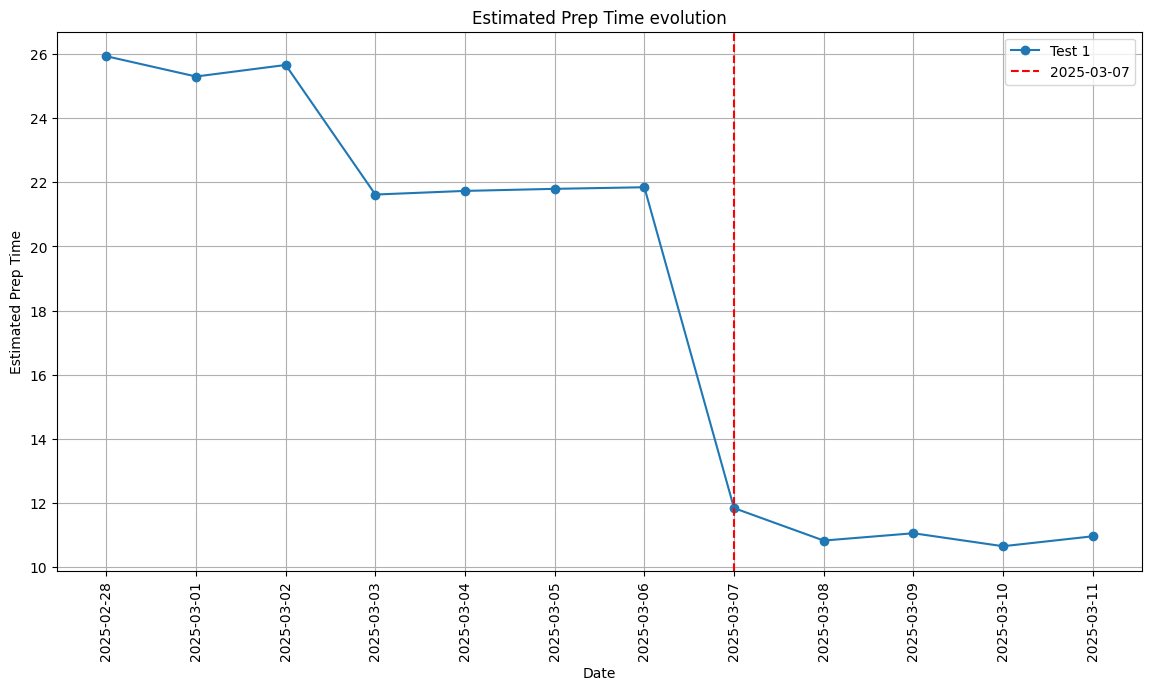

In [27]:
df_test_1 = fecha

# Crear la figura y los ejes
plt.figure(figsize=(14, 7))

# Graficar los datos
plt.plot(df_test_1['logistic_orders_created_date_local_date'], df_test_1['avg_estimated_prep_time'], label='Test 1', marker='o')


# Añadir líneas verticales
plt.axvline(pd.to_datetime(fecha_cambio), color='r', linestyle='--', label=fecha_cambio)

# Añadir etiquetas y título
plt.xlabel('Date')
plt.ylabel('Estimated Prep Time')
plt.title('Estimated Prep Time evolution')
plt.legend()

# Mostrar todos los valores del eje x
plt.xticks(df_test_1['logistic_orders_created_date_local_date'], rotation=90)

# Mostrar el gráfico
plt.grid(True)
plt.show()

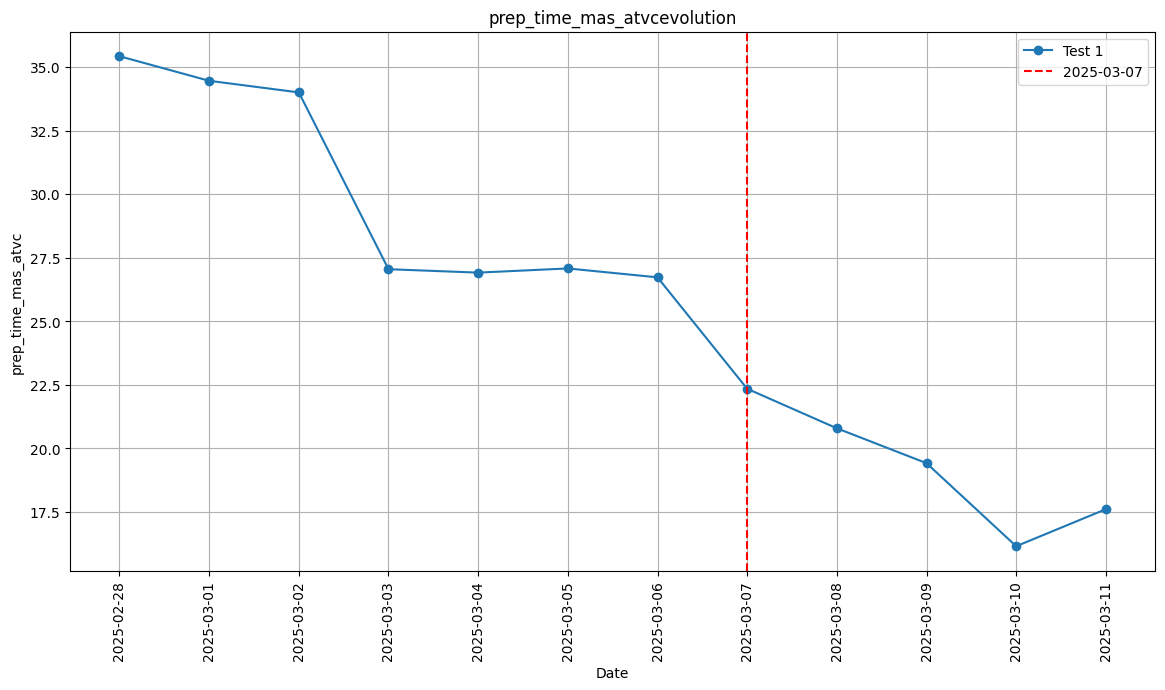

In [28]:
df_test_1 = fecha

# Crear la figura y los ejes
plt.figure(figsize=(14, 7))

# Graficar los datos
plt.plot(df_test_1['logistic_orders_created_date_local_date'], df_test_1['prep_time_mas_atvc'], label='Test 1', marker='o')


# Añadir líneas verticales
plt.axvline(pd.to_datetime(fecha_cambio), color='r', linestyle='--', label=fecha_cambio)

# Añadir etiquetas y título
plt.xlabel('Date')
plt.ylabel('prep_time_mas_atvc')
plt.title('prep_time_mas_atvcevolution')
plt.legend()

# Mostrar todos los valores del eje x
plt.xticks(df_test_1['logistic_orders_created_date_local_date'], rotation=90)

# Mostrar el gráfico
plt.grid(True)
plt.show()

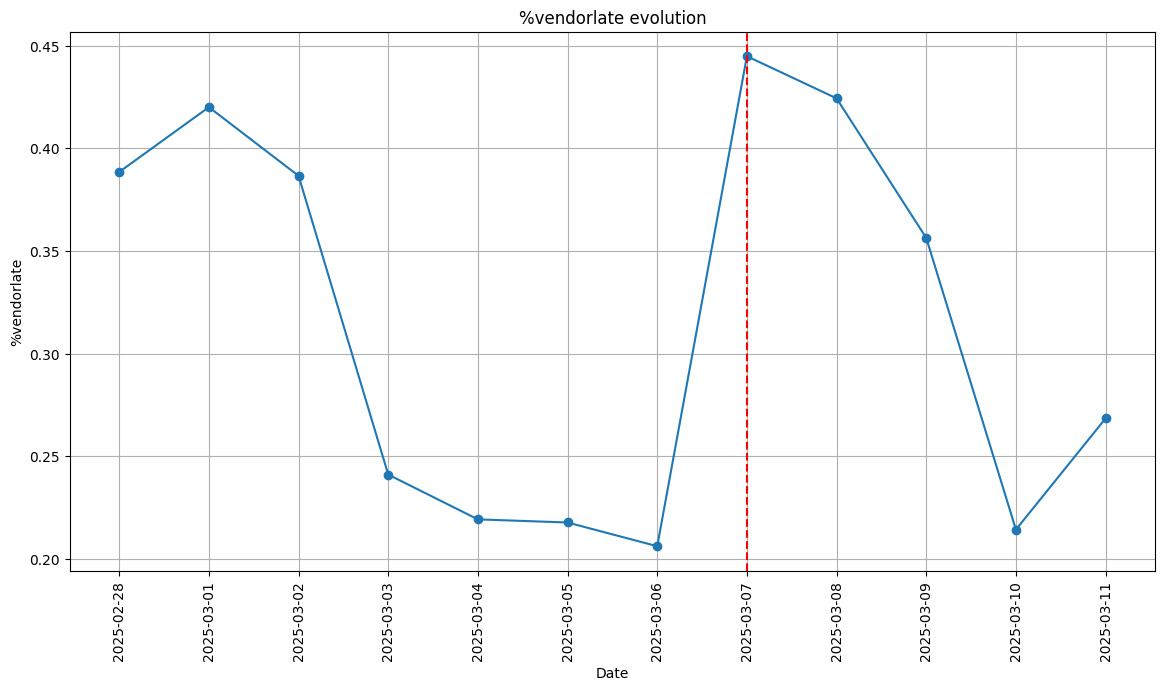

In [29]:
df_test_1 = fecha

# Crear la figura y los ejes
plt.figure(figsize=(14, 7))

# Graficar los datos
plt.plot(df_test_1['logistic_orders_created_date_local_date'], df_test_1['%vendorlate'], label='Test 1', marker='o')


# Añadir líneas verticales
plt.axvline(pd.to_datetime(fecha_cambio), color='r', linestyle='--', label=fecha_cambio)

# Añadir etiquetas y título
plt.xlabel('Date')
plt.ylabel('%vendorlate')
plt.title('%vendorlate evolution')
# plt.legend()

# Mostrar todos los valores del eje x
plt.xticks(df_test_1['logistic_orders_created_date_local_date'], rotation=90)

# Mostrar el gráfico
plt.grid(True)
plt.show()

In [21]:
df1.columns

Index(['Unnamed: 0', 'logistic_orders_country__country_name',
       'logistic_orders_created_date_local_week',
       'logistic_orders_created_date_local_date', 'dim_partner_partner_name',
       'dim_partner_partner_id', 'warehouse_name', 'warehouse_id',
       'business_type_name', 'cuisine', 'city',
       'logistic_orders_created_at_local_hour_of_day',
       'logistic_orders_created_date_local_day_of_week', 'franchise_name',
       'avg_vendorlate', 'logistic_orders_kpi_percentage_vendor_late_10',
       'is_vendor_late_10', 'is_vendor_late_nn', 'is_rider_late_10',
       'is_rider_late_nn', 'sum_estimated_prep_time',
       'orders_estimated_prep_time', 'orders_slow_delivery', 'Orders',
       'orders_lcf', 'sum_at_vendor_time_cleaned', 'orders_at_vendor_cleaned',
       'sum_assumed_prep_time', 'orders_assumed_prep_time', '% slow delivery',
       'Partners Partner ID', 'PQP_Advisor', 'dia', 'horario', 'Partner_id',
       'Mall', 'mall', 'Limite de Prep Time Franchise',
      

In [31]:
dfaux=df1[(df1["business_type_name"].isin(["Restaurant"] ))  & (df1["logistic_orders_created_date_local_date"]>="2025-02-28")   & (~df1["logistic_orders_created_date_local_date"].isin(["2025-03-05","2025-03-06"]))  & (df1["dim_partner_partner_id"].isin(cambios_id) )]


grouped = dfaux.groupby(['grupo']).agg({'orders_slow_delivery':'sum','is_vendor_late_10': 'sum', 'is_vendor_late_nn': 'sum','is_rider_late_10': 'sum', 'is_rider_late_nn': 'sum','sum_estimated_prep_time':'sum','orders_estimated_prep_time':'sum','sum_assumed_prep_time':'sum','orders_assumed_prep_time':'sum','sum_at_vendor_time_cleaned':'sum','orders_at_vendor_cleaned':'sum', 'Orders': 'sum'})
grouped['%vendorlate'] =grouped['is_vendor_late_10'] / grouped['is_vendor_late_nn']
grouped['%riderlate'] =grouped['is_rider_late_10'] / grouped['is_rider_late_nn']
grouped['%slowdelivery'] =grouped['orders_slow_delivery'] / grouped['Orders']

grouped['avg_estimated_prep_time'] =grouped['sum_estimated_prep_time'] / grouped['orders_estimated_prep_time']
grouped['avg_assumed_actual_prep_time'] =grouped['sum_assumed_prep_time'] / grouped['orders_assumed_prep_time']
grouped['avg_at_vendor_time_cleaned'] =grouped['sum_at_vendor_time_cleaned'] / grouped['orders_at_vendor_cleaned']
grouped['diff_estimacion'] =grouped['avg_assumed_actual_prep_time'] -grouped['avg_estimated_prep_time']

grouped['prep_time_mas_atvc'] =grouped['avg_estimated_prep_time'] +grouped['avg_at_vendor_time_cleaned']

prueba=pd.DataFrame(grouped[['%slowdelivery','%vendorlate','%riderlate','avg_estimated_prep_time','avg_assumed_actual_prep_time','diff_estimacion','avg_at_vendor_time_cleaned','Orders','prep_time_mas_atvc']])
prueba=prueba.reset_index()

total_orders=prueba["Orders"].sum()
#prueba["%_orders"]=prueba["Orders"]/total_orders
prueba


C:\Users\raul.raggio\AppData\Local\Temp\ipykernel_23772\2508205914.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  dfaux=df1[(df1["business_type_name"].isin(["Restaurant"] ))  & (df1["logistic_orders_created_date_local_date"]>="2025-02-28")   & (~df1["logistic_orders_created_date_local_date"].isin(["2025-03-05","2025-03-06"]))  & (df1["dim_partner_partner_id"].isin(cambios_id) )]


,grupo,%slowdelivery,%vendorlate,%riderlate,avg_estimated_prep_time,avg_assumed_actual_prep_time,diff_estimacion,avg_at_vendor_time_cleaned,Orders,prep_time_mas_atvc
0,cambio,0.228386,0.362038,0.101617,11.113232,14.724010,3.610778,8.639311,8328.0,19.752543
1,comparacion,0.503066,0.342909,0.163740,24.448301,26.745625,2.297324,7.791799,9623.0,32.240100


In [32]:
dfaux=df1[(df1["business_type_name"].isin(["Restaurant"] ))  & (df1["logistic_orders_created_date_local_date"]>="2025-02-28")   & (~df1["logistic_orders_created_date_local_date"].isin(["2025-03-05","2025-03-06"]))  & (df1["dim_partner_partner_id"].isin(cambios_id) )]


grouped = dfaux.groupby(['dim_partner_partner_id','dim_partner_partner_name','PQP_Advisor','grupo']).agg({'orders_slow_delivery':'sum','is_vendor_late_10': 'sum', 'is_vendor_late_nn': 'sum','is_rider_late_10': 'sum', 'is_rider_late_nn': 'sum','sum_estimated_prep_time':'sum','orders_estimated_prep_time':'sum','sum_assumed_prep_time':'sum','orders_assumed_prep_time':'sum','sum_at_vendor_time_cleaned':'sum','orders_at_vendor_cleaned':'sum', 'Orders': 'sum'})
grouped['%vendorlate'] =grouped['is_vendor_late_10'] / grouped['is_vendor_late_nn']
grouped['%riderlate'] =grouped['is_rider_late_10'] / grouped['is_rider_late_nn']
grouped['%slowdelivery'] =grouped['orders_slow_delivery'] / grouped['Orders']

grouped['avg_estimated_prep_time'] =grouped['sum_estimated_prep_time'] / grouped['orders_estimated_prep_time']
grouped['avg_assumed_actual_prep_time'] =grouped['sum_assumed_prep_time'] / grouped['orders_assumed_prep_time']
grouped['avg_at_vendor_time_cleaned'] =grouped['sum_at_vendor_time_cleaned'] / grouped['orders_at_vendor_cleaned']
grouped['diff_estimacion'] =grouped['avg_assumed_actual_prep_time'] -grouped['avg_estimated_prep_time']

grouped['prep_time_mas_atvc'] =grouped['avg_estimated_prep_time'] +grouped['avg_at_vendor_time_cleaned']

prueba=pd.DataFrame(grouped[['%slowdelivery','%vendorlate','%riderlate','avg_estimated_prep_time','avg_assumed_actual_prep_time','diff_estimacion','avg_at_vendor_time_cleaned','Orders','prep_time_mas_atvc']])
prueba=prueba.reset_index()

total_orders=prueba["Orders"].sum()
#prueba["%_orders"]=prueba["Orders"]/total_orders

prueba_pivot = prueba.pivot(index=["dim_partner_partner_id","dim_partner_partner_name","PQP_Advisor"], columns='grupo')
prueba_pivot.columns = ['_'.join(col).strip() for col in prueba_pivot.columns.values]
prueba_pivot.reset_index(inplace=True)

prueba_pivot["var_vl"]=prueba_pivot["%vendorlate_cambio"]-prueba_pivot["%vendorlate_comparacion"]
prueba_pivot["var_ept"]=prueba_pivot["avg_estimated_prep_time_cambio"]-prueba_pivot["avg_estimated_prep_time_comparacion"]

partner=prueba_pivot.copy()
partner=partner.merge(partners_cambios, how='left', left_on='dim_partner_partner_id', right_on='CODE')
partner

C:\Users\raul.raggio\AppData\Local\Temp\ipykernel_23772\3412288130.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  dfaux=df1[(df1["business_type_name"].isin(["Restaurant"] ))  & (df1["logistic_orders_created_date_local_date"]>="2025-02-28")   & (~df1["logistic_orders_created_date_local_date"].isin(["2025-03-05","2025-03-06"]))  & (df1["dim_partner_partner_id"].isin(cambios_id) )]


,dim_partner_partner_id_x,dim_partner_partner_name_x,PQP_Advisor,%slowdelivery_cambio,%slowdelivery_comparacion,%vendorlate_cambio,%vendorlate_comparacion,%riderlate_cambio,%riderlate_comparacion,avg_estimated_prep_time_cambio,...,diff_limite_%,%_orders,partner_id,cambio_final_cateogry,CODE,DAY-RANGE,HOUR-RANGE,PREPARATION-BUFFER,PREPARATION-TIME,STRATEGY
0,7696.0,china town reñaca,Sin PQP,0.000000,0.307692,0.416667,0.238095,0.000000,0.086957,10.000,...,1.356863,0.003953,7696,categoria_3,7696,MONDAY-SUNDAY,0-23,1,10,OPS_PERMANENT
1,48599.0,shawarma el porvenir,Sin PQP,0.242424,0.647059,0.428571,0.333333,0.125000,0.181818,14.000,...,1.410000,0.002325,48599,categoria_2,48599,MONDAY-SUNDAY,0-23,1,14,OPS_PERMANENT
2,49975.0,dunkin' apumanque,Javier Peñaloza,0.125000,0.261905,0.142857,0.297297,0.066667,0.097561,8.625,...,1.175000,0.004650,49975,categoria_2,49975,MONDAY-SUNDAY,0-23,1,8,OPS_PERMANENT
3,53377.0,"pedro, juan y diego - plaza alameda",Franco Lagos KA,0.294118,0.714286,0.312500,0.689655,0.000000,0.275000,8.000,...,1.076190,0.001628,53377,categoria_2,53377,MONDAY-SUNDAY,0-23,1,8,OPS_PERMANENT
4,57297.0,dominó - marina arauco,Javier Peñaloza,0.400000,0.823529,0.555556,0.555556,0.100000,0.470588,6.000,...,1.200000,0.001395,57297,categoria_2,57297,MONDAY-SUNDAY,0-23,1,6,OPS_PERMANENT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,528506.0,texas burger - iquique,no PQP,0.571429,1.000000,1.000000,0.600000,0.142857,0.375000,16.000,...,1.684211,0.000233,528506,categoria_2,528506,MONDAY-SUNDAY,0-23,1,16,OPS_PERMANENT
92,532873.0,wendy's eu gran avenida,no PQP,0.189189,0.551282,0.406250,0.416667,0.123288,0.200000,12.000,...,1.225371,0.009068,532873,categoria_2,532873,MONDAY-SUNDAY,0-23,1,12,OPS_PERMANENT
93,534322.0,"pedro, juan y diego- rancagua cuevas",no PQP,0.200000,0.514706,0.464286,0.305085,0.034483,0.092308,11.000,...,1.462319,0.010695,534322,categoria_1,534322,MONDAY-SUNDAY,0-23,1,11,OPS_PERMANENT
94,535811.0,carl's jr cenco la florida,no PQP,0.529412,0.809524,0.500000,0.444444,0.294118,0.325000,14.000,...,1.297619,0.001860,535811,categoria_2,535811,MONDAY-SUNDAY,0-23,1,14,OPS_PERMANENT


In [38]:
partner['accion'] = np.where(partner['var_vl'] > var_vl_limite, 'rollback', 'exito')
partner['PREPARATION-TIME'] = np.where(partner['accion'] == 'rollback', 
                                partner['avg_estimated_prep_time_cambio'] * 1.5, 
                                partner['avg_estimated_prep_time_cambio'] * 0.75)
partner["PREPARATION-TIME"] = round(partner["PREPARATION-TIME"])

partner

,dim_partner_partner_id_x,dim_partner_partner_name_x,PQP_Advisor,%slowdelivery_cambio,%slowdelivery_comparacion,%vendorlate_cambio,%vendorlate_comparacion,%riderlate_cambio,%riderlate_comparacion,avg_estimated_prep_time_cambio,...,%_orders,partner_id,cambio_final_cateogry,CODE,DAY-RANGE,HOUR-RANGE,PREPARATION-BUFFER,PREPARATION-TIME,STRATEGY,accion
0,7696.0,china town reñaca,Sin PQP,0.000000,0.307692,0.416667,0.238095,0.000000,0.086957,10.000,...,0.003953,7696,categoria_3,7696,MONDAY-SUNDAY,0-23,1,15.0,OPS_PERMANENT,rollback
1,48599.0,shawarma el porvenir,Sin PQP,0.242424,0.647059,0.428571,0.333333,0.125000,0.181818,14.000,...,0.002325,48599,categoria_2,48599,MONDAY-SUNDAY,0-23,1,21.0,OPS_PERMANENT,rollback
2,49975.0,dunkin' apumanque,Javier Peñaloza,0.125000,0.261905,0.142857,0.297297,0.066667,0.097561,8.625,...,0.004650,49975,categoria_2,49975,MONDAY-SUNDAY,0-23,1,6.0,OPS_PERMANENT,exito
3,53377.0,"pedro, juan y diego - plaza alameda",Franco Lagos KA,0.294118,0.714286,0.312500,0.689655,0.000000,0.275000,8.000,...,0.001628,53377,categoria_2,53377,MONDAY-SUNDAY,0-23,1,6.0,OPS_PERMANENT,exito
4,57297.0,dominó - marina arauco,Javier Peñaloza,0.400000,0.823529,0.555556,0.555556,0.100000,0.470588,6.000,...,0.001395,57297,categoria_2,57297,MONDAY-SUNDAY,0-23,1,4.0,OPS_PERMANENT,exito
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,528506.0,texas burger - iquique,no PQP,0.571429,1.000000,1.000000,0.600000,0.142857,0.375000,16.000,...,0.000233,528506,categoria_2,528506,MONDAY-SUNDAY,0-23,1,24.0,OPS_PERMANENT,rollback
92,532873.0,wendy's eu gran avenida,no PQP,0.189189,0.551282,0.406250,0.416667,0.123288,0.200000,12.000,...,0.009068,532873,categoria_2,532873,MONDAY-SUNDAY,0-23,1,9.0,OPS_PERMANENT,exito
93,534322.0,"pedro, juan y diego- rancagua cuevas",no PQP,0.200000,0.514706,0.464286,0.305085,0.034483,0.092308,11.000,...,0.010695,534322,categoria_1,534322,MONDAY-SUNDAY,0-23,1,16.0,OPS_PERMANENT,rollback
94,535811.0,carl's jr cenco la florida,no PQP,0.529412,0.809524,0.500000,0.444444,0.294118,0.325000,14.000,...,0.001860,535811,categoria_2,535811,MONDAY-SUNDAY,0-23,1,21.0,OPS_PERMANENT,rollback


In [39]:
partner[partner['accion']=="exito" ]

,dim_partner_partner_id_x,dim_partner_partner_name_x,PQP_Advisor,%slowdelivery_cambio,%slowdelivery_comparacion,%vendorlate_cambio,%vendorlate_comparacion,%riderlate_cambio,%riderlate_comparacion,avg_estimated_prep_time_cambio,...,%_orders,partner_id,cambio_final_cateogry,CODE,DAY-RANGE,HOUR-RANGE,PREPARATION-BUFFER,PREPARATION-TIME,STRATEGY,accion
2,49975.0,dunkin' apumanque,Javier Peñaloza,0.125000,0.261905,0.142857,0.297297,0.066667,0.097561,8.625000,...,0.004650,49975,categoria_2,49975,MONDAY-SUNDAY,0-23,1,6.0,OPS_PERMANENT,exito
3,53377.0,"pedro, juan y diego - plaza alameda",Franco Lagos KA,0.294118,0.714286,0.312500,0.689655,0.000000,0.275000,8.000000,...,0.001628,53377,categoria_2,53377,MONDAY-SUNDAY,0-23,1,6.0,OPS_PERMANENT,exito
4,57297.0,dominó - marina arauco,Javier Peñaloza,0.400000,0.823529,0.555556,0.555556,0.100000,0.470588,6.000000,...,0.001395,57297,categoria_2,57297,MONDAY-SUNDAY,0-23,1,4.0,OPS_PERMANENT,exito
5,63801.0,burger king® - la dehesa,Franco Lagos KA,0.108696,0.241830,0.400000,0.382353,0.083969,0.093333,6.072464,...,0.017903,63801,categoria_2,63801,MONDAY-SUNDAY,0-23,1,5.0,OPS_PERMANENT,exito
6,66557.0,burger king® - la florida,Franco Lagos KA,0.086957,0.351852,0.333333,0.454545,0.086957,0.169811,7.000000,...,0.004185,66557,categoria_2,66557,MONDAY-SUNDAY,0-23,1,5.0,OPS_PERMANENT,exito
7,67018.0,mcdonald's vespucio exterior,Javier Peñaloza,0.133333,0.299363,0.343066,0.296610,0.055172,0.213333,8.160000,...,0.014183,67018,categoria_2,67018,MONDAY-SUNDAY,0-23,1,6.0,OPS_PERMANENT,exito
8,67830.0,pizza hut - mall plaza tobalaba,Franco Lagos KA,0.166667,0.512821,0.300000,0.312500,0.130435,0.135135,11.000000,...,0.002558,67830,categoria_3,67830,MONDAY-SUNDAY,0-23,1,8.0,OPS_PERMANENT,exito
10,87802.0,buffet express el trebol,javier Peñaloza,0.150000,0.280000,0.250000,0.333333,0.200000,0.160000,9.000000,...,0.004883,87802,categoria_2,87802,MONDAY-SUNDAY,0-23,1,7.0,OPS_PERMANENT,exito
11,88287.0,melt pizzas - la florida,Franco Lagos KA,0.320896,0.647059,0.425743,0.400000,0.158333,0.255319,14.007463,...,0.012090,88287,categoria_2,88287,MONDAY-SUNDAY,0-23,1,11.0,OPS_PERMANENT,exito
13,106538.0,doggis mall arauco maipú,Franco Lagos KA,0.352941,0.789474,0.400000,0.692308,0.117647,0.187500,15.000000,...,0.000698,106538,categoria_2,106538,MONDAY-SUNDAY,0-23,1,11.0,OPS_PERMANENT,exito


In [41]:
partner.to_csv("resultados.csv")

In [26]:
partner["var_ept"].mean()

np.float64(-12.680124715537522)

In [40]:
55     /96

0.5729166666666666

In [28]:
partner.groupby(["accion","cambio_final_cateogry"]).agg({"dim_partner_partner_id":"count"}).reset_index()

,accion,cambio_final_cateogry,dim_partner_partner_id
0,exito,categoria_1,8
1,exito,categoria_2,55
2,exito,categoria_3,12
3,rollback,categoria_2,31
4,rollback,categoria_3,13


In [29]:
59/(59+27)

0.686046511627907

In [30]:
fecha_cambio="2024-11-27"
conditions = [
    (df1['logistic_orders_created_date_local_date'] >= fecha_cambio) ,
    (df1['logistic_orders_created_date_local_date'] < fecha_cambio) ,
]

values = ['cambio','comparacion']

# Por defecto, si no cumple ninguna de las condiciones anteriores, se asigna 'otras_fechas'
df1['grupo'] = np.select(conditions, values, default='no_considerar')

In [31]:
#dfaux=df1[(df1["business_type_name"].isin(["Restaurant","Coffee"] ))  & (df1["logistic_orders_created_date_local_date"]>="2024-10-21")  & (df1["logistic_orders_created_date_local_date"]<="2024-11-21")  & (~df1["logistic_orders_created_date_local_date"].isin(["2024-11-24"]))  & (df1["dim_partner_partner_id"].isin(cambios_id) )]
dfaux=df1[(df1["business_type_name"].isin(["Restaurant","Coffee"] ))  & (df1["logistic_orders_created_date_local_date"]>="2024-10-21")  & (~df1["logistic_orders_created_date_local_date"].isin(["2024-11-24"]))  & (df1["dim_partner_partner_id"].isin([90075,
117061,
131405,
134453,
140874,
222464,
355429,
377048,
388280,
416348,
433595,
447986,
472651,
478947]) )]

grouped = dfaux.groupby(['dim_partner_partner_id','dim_partner_partner_name','PQP_Advisor','grupo']).agg({'orders_slow_delivery':'sum','is_vendor_late_10': 'sum', 'is_vendor_late_nn': 'sum','is_rider_late_10': 'sum', 'is_rider_late_nn': 'sum','sum_estimated_prep_time':'sum','orders_estimated_prep_time':'sum','sum_assumed_prep_time':'sum','orders_assumed_prep_time':'sum','sum_at_vendor_time_cleaned':'sum','orders_at_vendor_cleaned':'sum', 'Orders': 'sum'})
grouped['%vendorlate'] =grouped['is_vendor_late_10'] / grouped['is_vendor_late_nn']
grouped['%riderlate'] =grouped['is_rider_late_10'] / grouped['is_rider_late_nn']
grouped['%slowdelivery'] =grouped['orders_slow_delivery'] / grouped['Orders']

grouped['avg_estimated_prep_time'] =grouped['sum_estimated_prep_time'] / grouped['orders_estimated_prep_time']
grouped['avg_assumed_actual_prep_time'] =grouped['sum_assumed_prep_time'] / grouped['orders_assumed_prep_time']
grouped['avg_at_vendor_time_cleaned'] =grouped['sum_at_vendor_time_cleaned'] / grouped['orders_at_vendor_cleaned']
grouped['diff_estimacion'] =grouped['avg_assumed_actual_prep_time'] -grouped['avg_estimated_prep_time']

grouped['prep_time_mas_atvc'] =grouped['avg_estimated_prep_time'] +grouped['avg_at_vendor_time_cleaned']

prueba=pd.DataFrame(grouped[['%slowdelivery','%vendorlate','%riderlate','avg_estimated_prep_time','avg_assumed_actual_prep_time','diff_estimacion','avg_at_vendor_time_cleaned','Orders','prep_time_mas_atvc']])
prueba=prueba.reset_index()

total_orders=prueba["Orders"].sum()
#prueba["%_orders"]=prueba["Orders"]/total_orders

prueba_pivot = prueba.pivot(index=["dim_partner_partner_id","dim_partner_partner_name","PQP_Advisor"], columns='grupo')
prueba_pivot.columns = ['_'.join(col).strip() for col in prueba_pivot.columns.values]
prueba_pivot.reset_index(inplace=True)

prueba_pivot["var_vl"]=prueba_pivot["%vendorlate_cambio"]-prueba_pivot["%vendorlate_comparacion"]
prueba_pivot["var_ept"]=prueba_pivot["avg_estimated_prep_time_cambio"]-prueba_pivot["avg_estimated_prep_time_comparacion"]

partner=prueba_pivot.copy()
partner=partner.merge(partners_cambios, how='left', left_on='dim_partner_partner_id', right_on='CODE')
partner

C:\Users\raul.raggio\AppData\Local\Temp\ipykernel_1836\920404117.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  dfaux=df1[(df1["business_type_name"].isin(["Restaurant","Coffee"] ))  & (df1["logistic_orders_created_date_local_date"]>="2024-10-21")  & (~df1["logistic_orders_created_date_local_date"].isin(["2024-11-24"]))  & (df1["dim_partner_partner_id"].isin([90075,


,dim_partner_partner_id,dim_partner_partner_name,PQP_Advisor,%slowdelivery_cambio,%slowdelivery_comparacion,%vendorlate_cambio,%vendorlate_comparacion,%riderlate_cambio,%riderlate_comparacion,avg_estimated_prep_time_cambio,...,prep_time_mas_atvc_comparacion,var_vl,var_ept,CODE,DAY-RANGE,HOUR-RANGE,PREPARATION-BUFFER,PREPARATION-TIME,STRATEGY,cambio_final_cateogry
0,90075.0,zbar,Sin PQP,0.615385,0.903226,0.600000,0.468085,0.375000,0.160714,21.000000,...,51.181167,0.131915,-21.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,117061.0,dunkin' vespucio - café,Javier Peñaloza,NaN,0.413793,NaN,0.250000,NaN,0.071429,NaN,...,28.338729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,131405.0,doggis mall paseo del mar,Franco Lagos KA,0.341176,0.580087,0.296296,0.278539,0.024096,0.026667,14.752941,...,34.089847,0.017757,-13.147492,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,134453.0,doggis mall del centro concepción,Franco Lagos KA,0.181818,0.462185,0.303030,0.251142,0.108108,0.051948,15.077922,...,34.574610,0.051889,-13.669977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,140874.0,juan maestro viña san martin,Franco Lagos KA,0.287234,0.166667,0.445783,0.129630,0.107527,0.068966,13.085106,...,28.138988,0.316154,-11.948227,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,222464.0,polleria peru brasil,SIN PQP,0.340909,0.442029,0.315789,0.320988,0.406250,0.276786,14.000000,...,30.958720,-0.005198,-11.615942,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,355429.0,la fuente peruana sanguchería & pizzas,Sin PQP,0.200000,0.668508,0.558140,0.303571,0.085106,0.045455,16.000000,...,40.408024,0.254568,-17.270718,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,377048.0,juan maestro limache,Franco Lagos KA,0.086957,0.329897,0.375000,0.256757,0.000000,0.086420,14.521739,...,31.833053,0.118243,-11.931869,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,388280.0,delicias caseras 862,Sin PQP,0.533333,0.854545,0.576923,0.472527,0.103448,0.080808,22.866667,...,48.496633,0.104396,-16.615152,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,416348.0,mercado rapid,SIN PQP,0.176471,0.370000,0.062500,0.134831,0.058824,0.072917,15.000000,...,33.995531,-0.072331,-15.260000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
partner['accion'] = np.where(partner['var_vl'] > var_vl_limite, 'rollback', 'exito')
partner['PREPARATION-TIME'] = np.where(partner['accion'] == 'rollback', 
                                partner['avg_estimated_prep_time_cambio'] * 1.5, 
                                partner['avg_estimated_prep_time_cambio'] * 0.75)
partner["PREPARATION-TIME"] = round(partner["PREPARATION-TIME"])

partner

,dim_partner_partner_id,dim_partner_partner_name,PQP_Advisor,%slowdelivery_cambio,%slowdelivery_comparacion,%vendorlate_cambio,%vendorlate_comparacion,%riderlate_cambio,%riderlate_comparacion,avg_estimated_prep_time_cambio,...,var_vl,var_ept,CODE,DAY-RANGE,HOUR-RANGE,PREPARATION-BUFFER,PREPARATION-TIME,STRATEGY,cambio_final_cateogry,accion
0,90075.0,zbar,Sin PQP,0.615385,0.903226,0.600000,0.468085,0.375000,0.160714,21.000000,...,0.131915,-21.750000,NaN,NaN,NaN,NaN,32.0,NaN,NaN,rollback
1,117061.0,dunkin' vespucio - café,Javier Peñaloza,NaN,0.413793,NaN,0.250000,NaN,0.071429,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,exito
2,131405.0,doggis mall paseo del mar,Franco Lagos KA,0.341176,0.580087,0.296296,0.278539,0.024096,0.026667,14.752941,...,0.017757,-13.147492,NaN,NaN,NaN,NaN,11.0,NaN,NaN,exito
3,134453.0,doggis mall del centro concepción,Franco Lagos KA,0.181818,0.462185,0.303030,0.251142,0.108108,0.051948,15.077922,...,0.051889,-13.669977,NaN,NaN,NaN,NaN,11.0,NaN,NaN,exito
4,140874.0,juan maestro viña san martin,Franco Lagos KA,0.287234,0.166667,0.445783,0.129630,0.107527,0.068966,13.085106,...,0.316154,-11.948227,NaN,NaN,NaN,NaN,20.0,NaN,NaN,rollback
5,222464.0,polleria peru brasil,SIN PQP,0.340909,0.442029,0.315789,0.320988,0.406250,0.276786,14.000000,...,-0.005198,-11.615942,NaN,NaN,NaN,NaN,10.0,NaN,NaN,exito
6,355429.0,la fuente peruana sanguchería & pizzas,Sin PQP,0.200000,0.668508,0.558140,0.303571,0.085106,0.045455,16.000000,...,0.254568,-17.270718,NaN,NaN,NaN,NaN,24.0,NaN,NaN,rollback
7,377048.0,juan maestro limache,Franco Lagos KA,0.086957,0.329897,0.375000,0.256757,0.000000,0.086420,14.521739,...,0.118243,-11.931869,NaN,NaN,NaN,NaN,22.0,NaN,NaN,rollback
8,388280.0,delicias caseras 862,Sin PQP,0.533333,0.854545,0.576923,0.472527,0.103448,0.080808,22.866667,...,0.104396,-16.615152,NaN,NaN,NaN,NaN,34.0,NaN,NaN,rollback
9,416348.0,mercado rapid,SIN PQP,0.176471,0.370000,0.062500,0.134831,0.058824,0.072917,15.000000,...,-0.072331,-15.260000,NaN,NaN,NaN,NaN,11.0,NaN,NaN,exito


In [ ]:
partner.to_csv("resultadosoleada2.csv")

In [ ]:
#VER ROLLBACK

In [34]:
rollback_ver=pd.read_csv("cambios_partners_que_esperan Noviembre - rollback csv.csv")

In [35]:
rollback_ver

,CODE,DAY-RANGE,HOUR-RANGE,PREPARATION-BUFFER,PREPARATION-TIME,STRATEGY
0,144011,MONDAY-SUNDAY,0-23,1,28,OPS_PERMANENT
1,55272,MONDAY-SUNDAY,0-23,1,13,OPS_PERMANENT
2,498585,MONDAY-SUNDAY,0-23,1,24,OPS_PERMANENT
3,191553,MONDAY-SUNDAY,0-23,1,8,OPS_PERMANENT
4,290354,MONDAY-SUNDAY,0-23,1,25,OPS_PERMANENT
5,488323,MONDAY-SUNDAY,0-23,1,25,OPS_PERMANENT
6,367053,MONDAY-SUNDAY,0-23,1,27,OPS_PERMANENT
7,431468,MONDAY-SUNDAY,0-23,1,22,OPS_PERMANENT
8,140876,MONDAY-SUNDAY,0-23,1,22,OPS_PERMANENT
9,139922,MONDAY-SUNDAY,0-23,1,19,OPS_PERMANENT


In [42]:
dfaux=df1[(df1["business_type_name"].isin(["Restaurant","Coffee"] ))  & (df1["logistic_orders_created_date_local_date"]>="2024-11-18")  & (df1["dim_partner_partner_id"].isin(rollback_ver["CODE"].values) )]

grouped = dfaux.groupby(['dim_partner_partner_id','dim_partner_partner_name','PQP_Advisor','grupo']).agg({'orders_slow_delivery':'sum','is_vendor_late_10': 'sum', 'is_vendor_late_nn': 'sum','is_rider_late_10': 'sum', 'is_rider_late_nn': 'sum','sum_estimated_prep_time':'sum','orders_estimated_prep_time':'sum','sum_assumed_prep_time':'sum','orders_assumed_prep_time':'sum','sum_at_vendor_time_cleaned':'sum','orders_at_vendor_cleaned':'sum', 'Orders': 'sum'})
grouped['%vendorlate'] =grouped['is_vendor_late_10'] / grouped['is_vendor_late_nn']
grouped['%riderlate'] =grouped['is_rider_late_10'] / grouped['is_rider_late_nn']
grouped['%slowdelivery'] =grouped['orders_slow_delivery'] / grouped['Orders']

grouped['avg_estimated_prep_time'] =grouped['sum_estimated_prep_time'] / grouped['orders_estimated_prep_time']
grouped['avg_assumed_actual_prep_time'] =grouped['sum_assumed_prep_time'] / grouped['orders_assumed_prep_time']
grouped['avg_at_vendor_time_cleaned'] =grouped['sum_at_vendor_time_cleaned'] / grouped['orders_at_vendor_cleaned']
grouped['diff_estimacion'] =grouped['avg_assumed_actual_prep_time'] -grouped['avg_estimated_prep_time']

grouped['prep_time_mas_atvc'] =grouped['avg_estimated_prep_time'] +grouped['avg_at_vendor_time_cleaned']

prueba=pd.DataFrame(grouped[['%slowdelivery','%vendorlate','%riderlate','avg_estimated_prep_time','avg_assumed_actual_prep_time','avg_at_vendor_time_cleaned','Orders','prep_time_mas_atvc']])
prueba=prueba.reset_index()

total_orders=prueba["Orders"].sum()
#prueba["%_orders"]=prueba["Orders"]/total_orders

prueba_pivot = prueba.pivot(index=["dim_partner_partner_id","dim_partner_partner_name","PQP_Advisor"], columns='grupo')
prueba_pivot.columns = ['_'.join(col).strip() for col in prueba_pivot.columns.values]
prueba_pivot.reset_index(inplace=True)

prueba_pivot["var_vl"]=prueba_pivot["%vendorlate_cambio"]-prueba_pivot["%vendorlate_comparacion"]
prueba_pivot["var_ept"]=prueba_pivot["avg_estimated_prep_time_cambio"]-prueba_pivot["avg_estimated_prep_time_comparacion"]

partner=prueba_pivot.copy()

partner.to_csv("resultadosrollback1.csv")
partner

,dim_partner_partner_id,dim_partner_partner_name,PQP_Advisor,%slowdelivery_cambio,%slowdelivery_comparacion,%vendorlate_cambio,%vendorlate_comparacion,%riderlate_cambio,%riderlate_comparacion,avg_estimated_prep_time_cambio,...,avg_assumed_actual_prep_time_cambio,avg_assumed_actual_prep_time_comparacion,avg_at_vendor_time_cleaned_cambio,avg_at_vendor_time_cleaned_comparacion,Orders_cambio,Orders_comparacion,prep_time_mas_atvc_cambio,prep_time_mas_atvc_comparacion,var_vl,var_ept
0,48974.0,el puro perú - providencia,Sin PQP,0.333333,0.319149,0.325581,0.657895,0.140000,0.136364,22.941176,...,27.021171,22.280000,7.279545,12.025000,51.0,47.0,30.220722,27.642021,-0.332313,7.324155
1,55272.0,dunkin' trébol terrazas,Javier Peñaloza,NaN,0.000000,NaN,0.222222,NaN,0.000000,NaN,...,NaN,11.970370,NaN,5.940741,NaN,9.0,NaN,14.829630,NaN,NaN
2,63756.0,pollo bravo,SIN PQP,0.083333,0.105263,0.181818,0.312500,0.083333,0.058824,15.000000,...,17.359649,16.912500,5.353030,8.667647,24.0,19.0,20.353030,18.667647,-0.130682,5.000000
3,65463.0,royal ranch,Franco Lagos Tier,0.468750,0.305638,0.439689,0.536741,0.098246,0.071217,23.305556,...,27.202778,20.247239,10.069703,11.566667,288.0,337.0,33.375258,27.640851,-0.097052,7.231372
4,68304.0,terraza bistró,Sin PQP,0.534483,0.414634,0.488889,0.636364,0.166667,0.175000,27.844828,...,31.694872,25.403704,8.734028,12.698039,58.0,41.0,36.578855,31.698039,-0.147475,8.844828
5,101351.0,tarragona la fábrica patio outlet,Javier Peñaloza,0.127119,0.146667,0.292237,0.352657,0.043668,0.050459,7.783898,...,12.327636,10.667593,6.926621,7.799289,236.0,225.0,14.710520,13.083734,-0.060420,2.499454
6,139922.0,itacate burritos - ciudad satélite,Franco Lagos KA,0.280702,0.333333,0.478261,0.706897,0.148148,0.171429,18.754386,...,22.995062,20.080702,10.047619,15.212147,57.0,72.0,28.802005,27.517702,-0.228636,6.448830
7,140876.0,doggis viña san martin,Franco Lagos KA,0.250000,0.227273,0.306818,0.340000,0.083333,0.047619,21.600000,...,25.565060,18.438158,5.805072,7.486859,100.0,110.0,27.405072,21.777768,-0.033182,7.309091
8,144011.0,restaurante macario,Sin PQP,0.459016,0.216667,0.237288,0.327273,0.016667,0.035088,25.540984,...,30.257971,22.374242,6.456389,6.109649,61.0,60.0,31.997372,25.426316,-0.089985,6.224317
9,149076.0,supremo sport bar,SIN PQP,0.340426,0.311111,0.357143,0.527778,0.066667,0.200000,19.404255,...,24.288172,19.402273,8.400000,10.633333,47.0,45.0,27.804255,23.633333,-0.170635,6.404255


In [102]:

if flag ==0:
    
    sql1 = """

 SELECT
    p.country.country_code,
  order_code,
  global_order_id,
  EXTRACT(DATE FROM DATETIME(ov2.created_at,ov2.timezone)) AS created_date,
  EXTRACT(HOUR FROM DATETIME(ov2.created_at ,ov2.timezone)) AS created_hour,

  vendor_code AS partner_id,
  franchise.franchise_name AS franchise_name,
  p.partner_name,
  p.warehouse_name  AS dim_partner_warehouse_name,
  p.business_type.business_type_name AS Business_Name,
  p.main_cousine_category_name AS main_cuisine,
  p.city.name AS City,
    CASE
        WHEN EXTRACT(DAYOFWEEK FROM DATETIME(ov2.created_at,ov2.timezone)) = 1 THEN 7
        WHEN EXTRACT(DAYOFWEEK FROM DATETIME(ov2.created_at,ov2.timezone)) = 2 THEN 1
        WHEN EXTRACT(DAYOFWEEK FROM DATETIME(ov2.created_at,ov2.timezone)) = 3 THEN 2
        WHEN EXTRACT(DAYOFWEEK FROM DATETIME(ov2.created_at,ov2.timezone)) = 4 THEN 3
        WHEN EXTRACT(DAYOFWEEK FROM DATETIME(ov2.created_at,ov2.timezone)) = 5 THEN 4
        WHEN EXTRACT(DAYOFWEEK FROM DATETIME(ov2.created_at,ov2.timezone)) = 6 THEN 5
        WHEN EXTRACT(DAYOFWEEK FROM DATETIME(ov2.created_at,ov2.timezone)) = 7 THEN 6
    END AS day_of_week_number,
    CASE
        WHEN EXTRACT(DAYOFWEEK FROM DATETIME(ov2.created_at,ov2.timezone)) IN (2, 3, 4, 5) THEN 'dia_de_semana'
        WHEN EXTRACT(DAYOFWEEK FROM DATETIME(ov2.created_at,ov2.timezone)) IN (6, 7, 1) THEN 'fin_de_semana'
    END AS dia_categoria,

    CASE
        WHEN EXTRACT(HOUR FROM DATETIME(ov2.created_at,ov2.timezone)) BETWEEN 0 AND 11 THEN '0-11'
        WHEN EXTRACT(HOUR FROM DATETIME(ov2.created_at,ov2.timezone)) BETWEEN 12 AND 14 THEN '12-14'
        WHEN EXTRACT(HOUR FROM DATETIME(ov2.created_at,ov2.timezone)) BETWEEN 15 AND 17 THEN '15-17'
        WHEN EXTRACT(HOUR FROM DATETIME(ov2.created_at,ov2.timezone)) BETWEEN 18 AND 20 THEN '18-20'
        WHEN EXTRACT(HOUR FROM DATETIME(ov2.created_at,ov2.timezone)) BETWEEN 21 AND 23 THEN '21-23'
    END AS time_slot,

  ROUND(DATETIME_DIFF(rider.food_is_ready_at,rider.sent_to_vendor_at, SECOND)/60,1) AS RPT,
  ROUND(rider.estimated_prep_time/60,1) AS EPT,
  ROUND(rider.estimated_prep_buffer/60,1) AS buffer,
  ROUND(SAFE_DIVIDE(
    DATETIME_DIFF(rider.food_is_ready_at,rider.sent_to_vendor_at, SECOND),
    rider.estimated_prep_time)*100) AS Ratio,
  COUNT(DISTINCT CASE WHEN rider.food_is_ready_at IS NOT NULL THEN ov2.order_code ELSE NULL END) AS orders_with_fir,
  COUNT(DISTINCT CASE WHEN ov2.vendor.order_status = 'completed' THEN order_code ELSE NULL END) AS confirmed_orders,
  COUNT(DISTINCT order_code) AS total_orders,
  
  COUNT(DISTINCT CASE WHEN ov2.rider.order_status = 'completed' AND ov2.rider.timings.vendor_late > 600 THEN ov2.order_code ELSE NULL END) AS VL_Num,
  COUNT(DISTINCT CASE WHEN ov2.rider.order_status = 'completed' AND ov2.rider.timings.vendor_late IS NOT NULL THEN ov2.order_code END) AS VL_Den,
  COUNT(DISTINCT CASE WHEN ov2.rider.order_status = 'completed' AND ov2.rider.timings.vendor_late > 600 AND rider.food_is_ready_at IS NOT NULL THEN ov2.order_code ELSE NULL END) AS VL_Num_FIR,
FROM `peya-data-origins-pro.cl_hurrier.orders_v2` ov2
LEFT JOIN `peya-bi-tools-pro.il_core.dim_partner` AS p
  ON vendor_code = CAST(partner_id AS STRING)
WHERE TRUE
  AND ov2.created_date between date_trunc(DATE_SUB(CURRENT_DATE("America/Santiago"), INTERVAL 1 MONTH), MONTH) and current_date()
  AND p.country_id = 2

  AND ov2.delivery_type = "OWN_DELIVERY"


GROUP BY 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
ORDER BY 2 DESC
    """
    data2=client.query(sql1).to_dataframe()
    data2.to_csv("data2.csv")
else:
    
    data2=pd.read_csv("data2.csv")

In [103]:
df2=data2
df2['orders_with_fir'] = df2['orders_with_fir'].astype(str).str.replace(',', '').astype(float)
df2['confirmed_orders'] = df2['confirmed_orders'].astype(str).str.replace(',', '').astype(float)
df2['total_orders'] = df2['total_orders'].astype(str).str.replace(',', '').astype(float)
df2['created_date'] = pd.to_datetime(df2['created_date'])
df2["diff"] = df2["RPT"] - df2["EPT"]
df2

MemoryError: Unable to allocate 239. MiB for an array with shape (7, 4466410) and data type float64

MemoryError: Unable to allocate 273. MiB for an array with shape (8, 4466410) and data type object

In [104]:
df2[df2["created_date"]=="2024-11-20"]

,country_code,order_code,global_order_id,created_date,created_hour,partner_id,franchise_name,partner_name,dim_partner_warehouse_name,Business_Name,...,EPT,buffer,Ratio,orders_with_fir,confirmed_orders,total_orders,VL_Num,VL_Den,VL_Num_FIR,diff
54,CL,obs-eedf43f5-bbea-418b-b42c-79f98561420c,obs-eedf43f5-bbea-418b-b42c-79f98561420c,2024-11-20,17,289949,Market PedidosYa,PedidosYa Market - Manquehue,CH_22_Manquehue,Market,...,7.0,0.0,40.0,1.0,0.0,1.0,0,0,0,-4.2
67,CL,obs-ebfa7f73-e6c5-4b1e-9146-3a69d72c619d,obs-ebfa7f73-e6c5-4b1e-9146-3a69d72c619d,2024-11-20,17,161839,Market PedidosYa,PedidosYa Market - Talca,CH_3_Talca,Market,...,8.0,0.0,31.0,1.0,0.0,1.0,0,1,0,-5.5
87,CL,obs-e5537588-e145-4856-962e-7be9a09bd51f,obs-e5537588-e145-4856-962e-7be9a09bd51f,2024-11-20,17,298399,Market PedidosYa,PedidosYa Market - Osorno,CH_23_Osorno,Market,...,7.0,0.0,39.0,1.0,0.0,1.0,0,1,0,-4.3
362,CL,obs-75a5251a-9562-4cb8-b741-afcd4df54423,obs-75a5251a-9562-4cb8-b741-afcd4df54423,2024-11-20,17,139761,Market PedidosYa,PedidosYa Market - Santiago,CH_1_Santiago,Market,...,13.0,0.0,22.0,1.0,0.0,1.0,0,0,0,-10.2
583,CL,obs-2cf3f66a-cb21-4468-9b0e-f5246ee6ccce,obs-2cf3f66a-cb21-4468-9b0e-f5246ee6ccce,2024-11-20,17,177613,Market PedidosYa,PedidosYa Market Viña Del Mar,CH_8_Vina del Mar,Market,...,7.0,0.0,63.0,1.0,0.0,1.0,0,1,0,-2.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154035,CL,1346886431,1346886431,2024-11-20,0,255912,Petrobras,Aramco - Botillería Vitacura Vespucio,None,Drinks,...,10.0,0.0,NaN,0.0,0.0,1.0,0,1,0,NaN
154036,CL,1346886420,1346886420,2024-11-20,0,65501,McDonald's,McDonald's Antofagasta Playa,None,Restaurant,...,8.0,3.0,NaN,0.0,0.0,1.0,1,1,0,NaN
154037,CL,1346886405,1346886405,2024-11-20,0,127159,Burger King,Burger King® - Dreams Temuco,None,Restaurant,...,12.0,2.0,NaN,0.0,0.0,1.0,0,1,0,NaN
154038,CL,1346886390,1346886390,2024-11-20,0,156367,Wing It LATAM,Wing It! - Antofagasta Norte,None,Restaurant,...,18.0,1.0,94.0,1.0,0.0,1.0,0,1,0,-1.1


In [41]:
conditions = [
    (df2['created_date'] >= fecha_cambio) ,
    (df2['created_date'] < fecha_cambio) ,
]

values = ['cambio','comparacion']

# Por defecto, si no cumple ninguna de las condiciones anteriores, se asigna 'otras_fechas'
df2['grupo'] = np.select(conditions, values, default='no_considerar')

In [42]:
cambios_id

array([ 42452,  47552,  48974,  49369,  53138,  55272,  59379,  62219,
        62714,  63756,  64028,  64239,  65463,  68304, 101351, 104989,
       109384, 125266, 129956, 130988, 139922, 140876, 142100, 144011,
       146926, 147474, 149076, 153599, 158530, 165483, 165750, 166897,
       174101, 181121, 191553, 198518, 199172, 199975, 205413, 205420,
       205428, 221862, 224743, 238173, 238788, 247349, 259378, 267397,
       283634, 286875, 290354, 298207, 301940, 309089, 313789, 315232,
       315244, 323185, 328393, 340949, 352620, 355488, 364058, 367053,
       367058, 372060, 377805, 393205, 393676, 394156, 396521, 404147,
       406329, 409077, 412851, 421757, 421997, 422023, 423116, 425093,
       425691, 425859, 426089, 431468, 432457, 434483, 441856, 443713,
       443905, 449230, 450847, 451081, 453610, 456226, 456329, 456487,
       470425, 482574, 483679, 484291, 488323, 488442, 488934, 489734,
       491977, 497139, 497738, 498585, 499738, 500572, 500973, 501341,
      

In [43]:
df2[(df2["partner_id"].isin(["229108"]))]

,Unnamed: 0,country_code,order_code,global_order_id,created_date,created_hour,partner_id,franchise_name,partner_name,dim_partner_warehouse_name,...,buffer,Ratio,orders_with_fir,confirmed_orders,total_orders,VL_Num,VL_Den,VL_Num_FIR,diff,grupo


In [44]:
dfaux=df2[(df2["RPT"]>0) & (df2["created_date"]>="2024-10-21")  & (df2["partner_id"].isin(cambios_id) )]
grouped = dfaux.groupby(['partner_id','partner_name','grupo']).agg({'RPT':'mean','EPT': 'mean'})


prueba=pd.DataFrame(grouped)
prueba=prueba.reset_index()
#prueba["diff"]=prueba["RPT"]-prueba["EPT"]
#prueba = prueba.sort_values(by='diff', ascending=False)

prueba_pivot = prueba.pivot(index=["partner_id","partner_name"], columns='grupo')
prueba_pivot.columns = ['_'.join(col).strip() for col in prueba_pivot.columns.values]
prueba_pivot=prueba_pivot.reset_index()
prueba_pivot



,partner_id,partner_name,RPT_cambio,RPT_comparacion,EPT_cambio,EPT_comparacion
0,47552,Juan Maestro Mall Plaza Oeste,NaN,17.933333,NaN,28.000000
1,48974,El Puro Perú - Providencia,18.080,28.619811,15.00,28.650943
2,49369,Tommy Beans Espacio M,NaN,28.425000,NaN,21.250000
3,53138,Dominó - Los Dominicos,NaN,24.477778,NaN,14.555556
4,55272,Dunkin' Trébol Terrazas,4.700,12.144444,8.00,14.444444
...,...,...,...,...,...,...
98,504483,Doggis - Espacio Urbano Punta Arenas,9.100,16.841818,18.00,34.309091
99,507910,Mastik 174,NaN,23.472059,NaN,24.147059
100,511118,Rochis - Espacio Urbano,13.000,21.066667,14.00,20.916667
101,511500,Peco - Comida Peruana,29.260,36.619048,14.00,27.738095


In [45]:
resultados_final=partner.merge(prueba_pivot, how='left', left_on='dim_partner_partner_id', right_on='partner_id')
resultados_final

,dim_partner_partner_id,dim_partner_partner_name,%slowdelivery_cambio,%slowdelivery_comparacion,%vendorlate_cambio,%vendorlate_comparacion,%riderlate_cambio,%riderlate_comparacion,avg_estimated_prep_time_cambio,avg_estimated_prep_time_comparacion,...,PREPARATION-TIME,STRATEGY,cambio_final_cateogry,accion,partner_id,partner_name,RPT_cambio,RPT_comparacion,EPT_cambio,EPT_comparacion
0,42452.0,kfc general velásquez,0.287500,0.492196,0.449275,0.238286,0.092105,0.170000,15.912500,27.621228,...,24.0,OPS_PERMANENT,categoria_2,rollback,NaN,NaN,NaN,NaN,NaN,NaN
1,47552.0,juan maestro mall plaza oeste,0.000000,0.405797,0.000000,0.156250,0.000000,0.058824,14.000000,28.000000,...,10.0,OPS_PERMANENT,categoria_1,exito,47552.0,Juan Maestro Mall Plaza Oeste,NaN,17.933333,NaN,28.000000
2,48974.0,el puro perú - providencia,0.500000,0.582278,0.888889,0.324873,0.181818,0.150862,17.416667,28.367089,...,26.0,OPS_PERMANENT,categoria_2,rollback,48974.0,El Puro Perú - Providencia,18.080,28.619811,15.00,28.650943
3,49369.0,tommy beans espacio m,0.250000,0.456140,0.333333,0.386364,0.000000,0.185185,16.500000,21.403509,...,12.0,OPS_PERMANENT,categoria_2,exito,49369.0,Tommy Beans Espacio M,NaN,28.425000,NaN,21.250000
4,53138.0,dominó - los dominicos,0.000000,0.308824,0.333333,0.321739,0.000000,0.135338,9.000000,13.897059,...,7.0,OPS_PERMANENT,categoria_2,exito,53138.0,Dominó - Los Dominicos,NaN,24.477778,NaN,14.555556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,504483.0,doggis - espacio urbano punta arenas,0.470588,0.839695,0.419355,0.480331,0.060606,0.052941,21.500000,33.158397,...,16.0,OPS_PERMANENT,categoria_1,exito,504483.0,Doggis - Espacio Urbano Punta Arenas,9.100,16.841818,18.00,34.309091
115,507910.0,mastik 174,0.000000,0.223684,0.000000,0.142857,0.000000,0.054054,12.000000,24.039474,...,9.0,OPS_PERMANENT,categoria_2,exito,507910.0,Mastik 174,NaN,23.472059,NaN,24.147059
116,511118.0,rochis - espacio urbano,0.333333,0.116883,0.333333,0.098592,0.000000,0.040541,12.666667,20.519481,...,19.0,OPS_PERMANENT,categoria_3,rollback,511118.0,Rochis - Espacio Urbano,13.000,21.066667,14.00,20.916667
117,511500.0,peco - comida peruana,0.333333,0.810345,0.000000,0.461538,0.333333,0.543860,14.000000,27.689655,...,10.0,OPS_PERMANENT,categoria_3,exito,511500.0,Peco - Comida Peruana,29.260,36.619048,14.00,27.738095


In [47]:
resultados_final.to_csv("resultados.csv")

In [48]:
resultados_final["diff_rpt"]=resultados_final["RPT_cambio"]-resultados_final["RPT_comparacion"] 
resultados_final

,dim_partner_partner_id,dim_partner_partner_name,%slowdelivery_cambio,%slowdelivery_comparacion,%vendorlate_cambio,%vendorlate_comparacion,%riderlate_cambio,%riderlate_comparacion,avg_estimated_prep_time_cambio,avg_estimated_prep_time_comparacion,...,STRATEGY,cambio_final_cateogry,accion,partner_id,partner_name,RPT_cambio,RPT_comparacion,EPT_cambio,EPT_comparacion,diff_rpt
0,42452.0,kfc general velásquez,0.287500,0.492196,0.449275,0.238286,0.092105,0.170000,15.912500,27.621228,...,OPS_PERMANENT,categoria_2,rollback,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,47552.0,juan maestro mall plaza oeste,0.000000,0.405797,0.000000,0.156250,0.000000,0.058824,14.000000,28.000000,...,OPS_PERMANENT,categoria_1,exito,47552.0,Juan Maestro Mall Plaza Oeste,NaN,17.933333,NaN,28.000000,NaN
2,48974.0,el puro perú - providencia,0.500000,0.582278,0.888889,0.324873,0.181818,0.150862,17.416667,28.367089,...,OPS_PERMANENT,categoria_2,rollback,48974.0,El Puro Perú - Providencia,18.080,28.619811,15.00,28.650943,-10.539811
3,49369.0,tommy beans espacio m,0.250000,0.456140,0.333333,0.386364,0.000000,0.185185,16.500000,21.403509,...,OPS_PERMANENT,categoria_2,exito,49369.0,Tommy Beans Espacio M,NaN,28.425000,NaN,21.250000,NaN
4,53138.0,dominó - los dominicos,0.000000,0.308824,0.333333,0.321739,0.000000,0.135338,9.000000,13.897059,...,OPS_PERMANENT,categoria_2,exito,53138.0,Dominó - Los Dominicos,NaN,24.477778,NaN,14.555556,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,504483.0,doggis - espacio urbano punta arenas,0.470588,0.839695,0.419355,0.480331,0.060606,0.052941,21.500000,33.158397,...,OPS_PERMANENT,categoria_1,exito,504483.0,Doggis - Espacio Urbano Punta Arenas,9.100,16.841818,18.00,34.309091,-7.741818
115,507910.0,mastik 174,0.000000,0.223684,0.000000,0.142857,0.000000,0.054054,12.000000,24.039474,...,OPS_PERMANENT,categoria_2,exito,507910.0,Mastik 174,NaN,23.472059,NaN,24.147059,NaN
116,511118.0,rochis - espacio urbano,0.333333,0.116883,0.333333,0.098592,0.000000,0.040541,12.666667,20.519481,...,OPS_PERMANENT,categoria_3,rollback,511118.0,Rochis - Espacio Urbano,13.000,21.066667,14.00,20.916667,-8.066667
117,511500.0,peco - comida peruana,0.333333,0.810345,0.000000,0.461538,0.333333,0.543860,14.000000,27.689655,...,OPS_PERMANENT,categoria_3,exito,511500.0,Peco - Comida Peruana,29.260,36.619048,14.00,27.738095,-7.359048


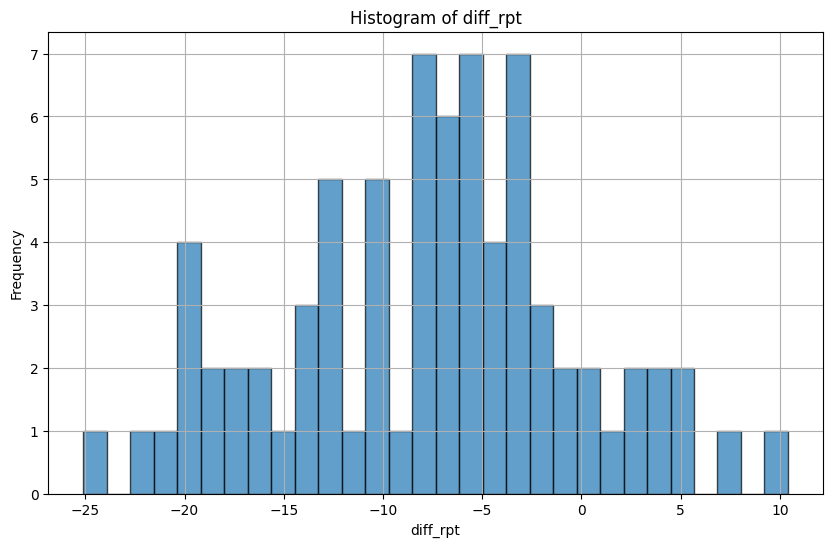

In [50]:
import matplotlib.pyplot as plt
dfaux=resultados_final
# Crear el histograma
plt.figure(figsize=(10, 6))
plt.hist(dfaux['diff_rpt'].dropna(), bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('diff_rpt')
plt.ylabel('Frequency')
plt.title('Histogram of diff_rpt')
plt.grid(True)
plt.show()

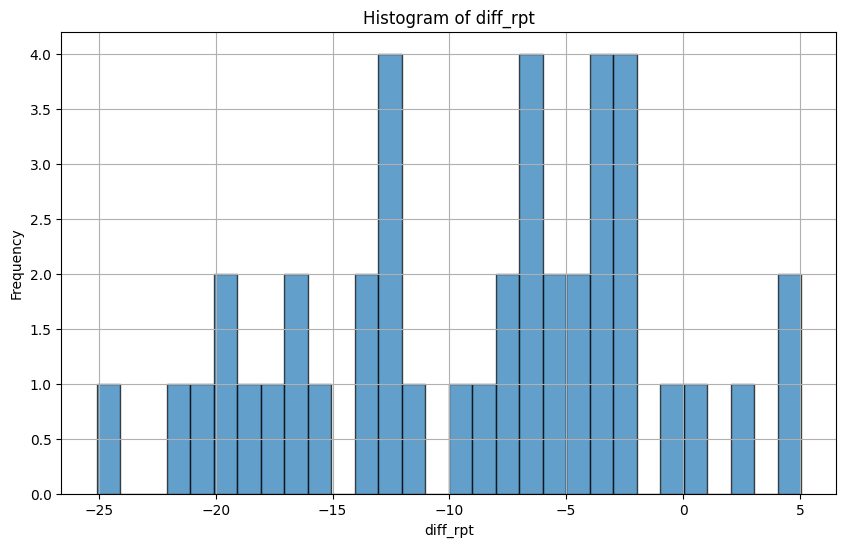

In [51]:
dfaux=resultados_final[resultados_final["accion"]=="exito"]
# Crear el histograma
plt.figure(figsize=(10, 6))
plt.hist(dfaux['diff_rpt'].dropna(), bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('diff_rpt')
plt.ylabel('Frequency')
plt.title('Histogram of diff_rpt')
plt.grid(True)
plt.show()